In [1]:
#pip install torch==1.9.0

In [2]:
#pip install deepxde

In [3]:
#pip install numpy

In [4]:
#pip install matplotlib

In [5]:
#pip install pandas

In [6]:
#pip install tensorflow

In [7]:
#pip install tensorflow_probability

In [8]:
#pip install tf-keras

In [9]:
#dde.backend.set_default_backend('tensorflow.compat.v1')

In [10]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [11]:
import deepxde as dde
import tensorflow.compat.v1 as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
dde.config.set_random_seed(1234)
dde.config.set_default_float("float64")

Set the default float type to float64


In [13]:
geom = dde.geometry.Rectangle([0, 0], [1, 1])

timedomain = dde.geometry.TimeDomain(0, 2)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [14]:
def pde(x, u):
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_y = dde.grad.jacobian(u, x, i=0, j=1)
    du_t = dde.grad.jacobian(u, x, i=0, j=2)
    
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    return du_t + u * (du_x+du_y) - (0.1) * (du_xx+du_yy)

# Soft-Soft

In [15]:
bc_top = dde.icbc.DirichletBC(geomtime, 
                              lambda x: 1/(1+np.exp( (x[:, 0:1]+1-x[:, 2:3])/0.2 )), 
                              lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 1.0),)

bc_bottom = dde.icbc.DirichletBC(geomtime,
                                 lambda x: 1/(1+np.exp( (x[:, 0:1]+0-x[:, 2:3])/0.2 )), 
                                 lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 0.0),)

bc_left = dde.icbc.DirichletBC(geomtime,
                               lambda x: 1/(1+np.exp( (0+x[:, 1:2]-x[:, 2:3])/0.2 )), 
                               lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0.0),)

bc_right = dde.icbc.DirichletBC(geomtime,
                                lambda x: 1/(1+np.exp( (1+x[:, 1:2]-x[:, 2:3])/0.2 )), 
                                lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 1.0),)


ic = dde.icbc.IC(geomtime, lambda x: 1/(1+np.exp( (x[:, 0:1]+x[:, 1:2])/0.2 )), lambda x, on_initial: on_initial and dde.utils.isclose(x[2], 0.0),)

In [16]:
data_ss = dde.data.TimePDE(geomtime, 
                        pde, 
                        [bc_top,
                         bc_bottom,
                         bc_left,
                         bc_right,
                         ic],
                        num_domain=500, 
                        num_boundary=100, 
                        num_initial=500,
                        train_distribution='Sobol')

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+103=103. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+101=101. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+501=501. 
  warnings.warn(


In [17]:
net_square_ss = dde.nn.FNN([3] + [20] * 20 + [1], "tanh", "Glorot uniform")
net_long_ss = dde.nn.FNN([3] + [20] * 5 + [1], "tanh", "Glorot uniform")
net_oblong_ss = dde.nn.FNN([3] + [5] * 20 + [1], "tanh", "Glorot uniform")

In [18]:
model_square_ss = dde.Model(data_ss, net_square_ss)
model_long_ss = dde.Model(data_ss, net_long_ss)
model_oblong_ss = dde.Model(data_ss, net_oblong_ss)

### Soft-Soft Square

In [81]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_square_ss.compile("adam", lr=0.001)
model_square_ss.train(iterations=1000, display_every=1000)
model_square_ss.compile("L-BFGS-B")
loss_history_square, train_state_square = model_square_ss.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.288562 s

'compile' took 2.604690 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.27e-04, 1.38e-01, 6.03e-01, 7.29e-01, 1.27e-01, 5.01e-03]    [4.27e-04, 1.38e-01, 6.03e-01, 7.29e-01, 1.27e-01, 5.01e-03]    []  
1000      [8.36e-05, 4.74e-04, 1.89e-04, 1.70e-04, 2.97e-04, 8.45e-05]    [8.36e-05, 4.74e-04, 1.89e-04, 1.70e-04, 2.97e-04, 8.45e-05]    []  

Best model at step 1000:
  train loss: 1.30e-03
  test loss: 1.30e-03
  test metric: []

'train' took 55.657572 s

Compiling model...
'compile' took 1.307386 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
1000      [8.36e-05, 4.74e-04, 1.89e-04, 1.70e-04, 2.97e-04, 8.45e-05]    [8.36e-05, 4.74e-04, 1.89e-04, 1.70e-04, 2.97e-04, 8.45e-05]    []  
2000      [6.21e-08

In [82]:
dde.utils.external.save_loss_history(loss_history_square, 'burgers_ss_square_loss')

Saving loss history to burgers_ss_square_loss ...


In [83]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_ss_square_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,1]
bc_loss = loss.reset_index().to_numpy()[:,2] + loss.reset_index().to_numpy()[:,3] + loss.reset_index().to_numpy()[:,4] + loss.reset_index().to_numpy()[:,5]
ic_loss = loss.reset_index().to_numpy()[:,6]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
bc_loss_array = np.append(bc_loss[:2], bc_loss[3:])
ic_loss_array = np.append(ic_loss[:2], ic_loss[3:])

In [85]:
loss1 = pde_loss_array + bc_loss_array + ic_loss_array

### Soft-Soft Long

In [19]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_long_ss.compile("adam", lr=0.001)
model_long_ss.train(iterations=1000, display_every=1000)
model_long_ss.compile("L-BFGS-B")
loss_history_long, train_state_long = model_long_ss.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'build' took 0.819790 s


'compile' took 1.482573 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.10e-02, 1.50e-01, 5.11e-01, 6.71e-01, 1.17e-01, 3.49e-02]    [2.10e-02, 1.50e-01, 5.11e-01, 6.71e-01, 1.17e-01, 3.49e-02]    []  
1000      [3.18e-04, 4.30e-05, 3.83e-05, 4.80e-05, 5.13e-05, 2.96e-05]    [3.18e-04, 4.30e-05, 3.83e-05, 4.80e-05, 5.13e-05, 2.96e-05]    []  

Best model at step 1000:
  train loss: 5.28e-04
  test loss: 5.28e-04
  test metric: []

'train' took 13.926472 s

Compiling model...
'compile' took 0.388221 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
1000      [3.18e-04, 4.30e-05, 3.83e-05, 4.80e-05, 5.13e-05, 2.96e-05]    [3.18e-04, 4.30e-05, 3.83e-05, 4.80e-05, 5.13e-05, 2.96e-05]    []  
2000      [2.99e-

In [20]:
dde.utils.external.save_loss_history(loss_history_long, 'burgers_ss_long_loss')

Saving loss history to burgers_ss_long_loss ...


In [21]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_ss_long_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,1]
bc_loss = loss.reset_index().to_numpy()[:,2] + loss.reset_index().to_numpy()[:,3] + loss.reset_index().to_numpy()[:,4] + loss.reset_index().to_numpy()[:,5]
ic_loss = loss.reset_index().to_numpy()[:,6]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
bc_loss_array = np.append(bc_loss[:2], bc_loss[3:])
ic_loss_array = np.append(ic_loss[:2], ic_loss[3:])

In [32]:
loss2 = pde_loss_array + bc_loss_array + ic_loss_array

### Soft-Soft Oblong

In [98]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_oblong_ss.compile("adam", lr=0.001)
model_oblong_ss.train(iterations=1000, display_every=1000)
model_oblong_ss.compile("L-BFGS-B")
loss_history_oblong, train_state_oblong = model_oblong_ss.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.376113 s

'compile' took 3.655693 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.70e-04, 1.13e-01, 5.90e-01, 6.49e-01, 1.24e-01, 4.34e-03]    [1.70e-04, 1.13e-01, 5.90e-01, 6.49e-01, 1.24e-01, 4.34e-03]    []  
1000      [1.63e-04, 2.31e-05, 5.28e-05, 3.40e-05, 9.75e-06, 3.56e-05]    [1.63e-04, 2.31e-05, 5.28e-05, 3.40e-05, 9.75e-06, 3.56e-05]    []  

Best model at step 1000:
  train loss: 3.19e-04
  test loss: 3.19e-04
  test metric: []

'train' took 41.943985 s

Compiling model...
'compile' took 3.159950 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
1000      [1.63e-04, 2.31e-05, 5.28e-05, 3.40e-05, 9.75e-06, 3.56e-05]    [1.63e-04, 2.31e-05, 5.28e-05

In [99]:
dde.utils.external.save_loss_history(loss_history_oblong, 'burgers_ss_oblong_loss')

Saving loss history to burgers_ss_oblong_loss ...


In [106]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_ss_oblong_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,1]
bc_loss = loss.reset_index().to_numpy()[:,2] + loss.reset_index().to_numpy()[:,3] + loss.reset_index().to_numpy()[:,4] + loss.reset_index().to_numpy()[:,5]
ic_loss = loss.reset_index().to_numpy()[:,6]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
bc_loss_array = np.append(bc_loss[:2], bc_loss[3:])
ic_loss_array = np.append(ic_loss[:2], ic_loss[3:])

In [107]:
loss3 = pde_loss_array + bc_loss_array + ic_loss_array

# Soft-Hard

In [33]:
data_sh = dde.data.TimePDE(geomtime, 
                        pde, 
                         [ic],
                        num_domain=500,
                        num_initial=100,
                        train_distribution='Sobol')

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+101=101. 
  warnings.warn(


In [34]:
def output_transform(x,u):
    return 1/(1+tf.exp( (x[:,0:1]+x[:,1:2]-x[:,2:3])/0.2 )) + x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u

In [35]:
net_square_sh = dde.nn.FNN([3] + [20] * 20 + [1], "tanh", "Glorot uniform")
net_long_sh = dde.nn.FNN([3] + [20] * 5 + [1], "tanh", "Glorot uniform")
net_oblong_sh = dde.nn.FNN([3] + [5] * 20 + [1], "tanh", "Glorot uniform")

In [36]:
net_square_sh.apply_output_transform(output_transform)
model_square_sh = dde.Model(data_sh, net_square_sh)

net_long_sh.apply_output_transform(output_transform)
model_long_sh = dde.Model(data_sh, net_long_sh)

net_oblong_sh.apply_output_transform(output_transform)
model_oblong_sh = dde.Model(data_sh, net_oblong_sh)

## Soft-Hard Square

In [86]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_square_sh.compile("adam", lr=0.001)
model_square_sh.train(iterations=1000, display_every=1000)
model_square_sh.compile("L-BFGS-B")
loss_history_square, train_state_square = model_square_sh.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.293919 s

'compile' took 3.193403 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.67e-04, 2.68e-06]    [5.67e-04, 2.68e-06]    []  
1000      [2.46e-09, 4.32e-11]    [2.46e-09, 4.32e-11]    []  

Best model at step 1000:
  train loss: 2.50e-09
  test loss: 2.50e-09
  test metric: []

'train' took 46.903984 s

Compiling model...
'compile' took 1.965716 s

Training model...

Step      Train loss              Test loss               Test metric
1000      [2.46e-09, 4.32e-11]    [2.46e-09, 4.32e-11]    []  
2000      [9.72e-14, 3.18e-15]    [9.72e-14, 3.18e-15]        
3000      [1.76e-15, 1.06e-16]    [1.76e-15, 1.06e-16]        
4000      [8.76e-16, 1.03e-16]    [8.76e-16, 1.03e-16]        
5000      [3.93e-16, 1.49e-17]    [3.93e-16, 1.49e-17]        
6000      [1.86e-16, 3.16e-18]    [1.86e-16, 3.16e-18]        
7000      [3.43e-17, 1.30e-18]    [3.43e-17, 1.30e-18]        
INFO:tensorflow:Optimization terminated w

In [87]:
dde.utils.external.save_loss_history(loss_history_square, 'burgers_sh_square_loss')

Saving loss history to burgers_sh_square_loss ...


In [91]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_sh_square_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,2]
ic_loss = loss.reset_index().to_numpy()[:,3]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
ic_loss_array = np.append(ic_loss[:2], ic_loss[3:])

In [92]:
loss4 = pde_loss_array + ic_loss_array

## Soft-Hard Long

In [37]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_long_sh.compile("adam", lr=0.001)
model_long_sh.train(iterations=1000, display_every=1000)
model_long_sh.compile("L-BFGS-B")
loss_history_long, train_state_long = model_long_sh.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.101704 s



C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.315426 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.69e-04, 4.54e-06]    [8.69e-04, 4.54e-06]    []  
1000      [1.05e-08, 2.89e-10]    [1.05e-08, 2.89e-10]    []  

Best model at step 1000:
  train loss: 1.08e-08
  test loss: 1.08e-08
  test metric: []

'train' took 8.759255 s

Compiling model...
'compile' took 0.701398 s

Training model...

Step      Train loss              Test loss               Test metric
1000      [1.05e-08, 2.89e-10]    [1.05e-08, 2.89e-10]    []  
2000      [6.49e-12, 2.04e-13]    [6.49e-12, 2.04e-13]        
3000      [1.24e-12, 1.11e-13]    [1.24e-12, 1.11e-13]        
4000      [2.89e-13, 3.86e-14]    [2.89e-13, 3.86e-14]        
5000      [8.16e-14, 5.93e-15]    [8.16e-14, 5.93e-15]        
6000      [4.32e-14, 8.53e-16]    [4.32e-14, 8.53e-16]        
7000      [1.89e-14, 5.53e-16]    [1.89e-14, 5.53e-16]        
8000      [9.75e-15, 8.47e-16]    [9.75e-15, 8.47e-16]        
9000

In [38]:
dde.utils.external.save_loss_history(loss_history_long, 'burgers_sh_long_loss')

Saving loss history to burgers_sh_long_loss ...


In [69]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_sh_long_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,2]
ic_loss = loss.reset_index().to_numpy()[:,3]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
ic_loss_array = np.append(ic_loss[:2], ic_loss[3:])

In [70]:
loss5 = pde_loss_array + ic_loss_array

## Soft-Hard Oblong

In [100]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_oblong_sh.compile("adam", lr=0.001)
model_oblong_sh.train(iterations=1000, display_every=1000)
model_oblong_sh.compile("L-BFGS-B")
loss_history_oblong, train_state_oblong = model_oblong_sh.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.288090 s

'compile' took 4.660858 s

Training model...

Step      Train loss              Test loss               Test metric
0         [9.16e-07, 2.59e-09]    [9.16e-07, 2.59e-09]    []  
1000      [4.87e-11, 3.96e-12]    [4.87e-11, 3.96e-12]    []  

Best model at step 1000:
  train loss: 5.27e-11
  test loss: 5.27e-11
  test metric: []

'train' took 24.036773 s

Compiling model...
'compile' took 2.756366 s

Training model...

Step      Train loss              Test loss               Test metric
1000      [4.87e-11, 3.96e-12]    [4.87e-11, 3.96e-12]    []  
2000      [8.64e-14, 7.11e-15]    [8.64e-14, 7.11e-15]        
3000      [4.02e-15, 2.30e-16]    [4.02e-15, 2.30e-16]        
4000      [2.53e-16, 2.00e-17]    [2.53e-16, 2.00e-17]        
5000      [1.40e-17, 1.66e-18]    [1.40e-17, 1.66e-18]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  O

In [101]:
dde.utils.external.save_loss_history(loss_history_oblong, 'burgers_sh_oblong_loss')

Saving loss history to burgers_sh_oblong_loss ...


In [109]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_sh_oblong_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,2]
ic_loss = loss.reset_index().to_numpy()[:,3]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
ic_loss_array = np.append(ic_loss[:2], ic_loss[3:])

In [110]:
loss6 = pde_loss_array + ic_loss_array

# Hard-Soft

In [41]:
data_hs = dde.data.TimePDE(geomtime, 
                        pde, 
                        [bc_top,
                         bc_bottom,
                         bc_left,
                         bc_right],
                        num_domain=500,
                        num_boundary=100,
                        train_distribution='Sobol')

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+103=103. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+101=101. 
  warnings.warn(


In [42]:
def output_transform(x,u):
    return 1/(1+tf.exp( (x[:,0:1]+x[:,1:2]-x[:,2:3])/0.2 )) + x[:,2:3] * u

In [43]:
net_square_hs = dde.nn.FNN([3] + [20] * 20 + [1], "tanh", "Glorot uniform")
net_long_hs = dde.nn.FNN([3] + [20] * 5 + [1], "tanh", "Glorot uniform")
net_oblong_hs = dde.nn.FNN([3] + [5] * 20 + [1], "tanh", "Glorot uniform")

In [44]:
net_square_hs.apply_output_transform(output_transform)
model_square_hs = dde.Model(data_hs, net_square_hs)

net_long_hs.apply_output_transform(output_transform)
model_long_hs = dde.Model(data_hs, net_long_hs)

net_oblong_hs.apply_output_transform(output_transform)
model_oblong_hs = dde.Model(data_hs, net_oblong_hs)

## Hard-Soft Square

In [94]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_square_hs.compile("adam", lr=0.001)
model_square_hs.train(iterations=1000, display_every=1000)
model_square_hs.compile("L-BFGS-B")
loss_history_square, train_state_square = model_square_hs.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.291285 s

'compile' took 3.224624 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.12e-02, 4.81e-02, 1.79e-03, 3.41e-02, 1.81e-02]    [6.12e-02, 4.81e-02, 1.79e-03, 3.41e-02, 1.81e-02]    []  
1000      [1.38e-07, 3.98e-08, 1.94e-08, 2.78e-08, 3.54e-08]    [1.38e-07, 3.98e-08, 1.94e-08, 2.78e-08, 3.54e-08]    []  

Best model at step 1000:
  train loss: 2.60e-07
  test loss: 2.60e-07
  test metric: []

'train' took 49.860762 s

Compiling model...
'compile' took 1.590584 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
1000      [1.38e-07, 3.98e-08, 1.94e-08, 2.78e-08, 3.54e-08]    [1.38e-07, 3.98e-08, 1.94e-08, 2.78e-08, 3.54e-08]    []  
2000      [1.14e-10, 5.92e-12, 1.28e-11, 2.35e-11, 1.13e-11]    [1.14e-10, 5.92e-12, 1.28e-11, 2.35e-11, 1.13e-11]     

In [95]:
dde.utils.external.save_loss_history(loss_history_square, 'burgers_hs_square_loss')

Saving loss history to burgers_hs_square_loss ...


In [125]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_hs_square_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,1]
bc_loss = loss.reset_index().to_numpy()[:,2] + loss.reset_index().to_numpy()[:,3] + loss.reset_index().to_numpy()[:,4] + loss.reset_index().to_numpy()[:,5] 

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
bc_loss_array = np.append(bc_loss[:2], bc_loss[3:])

In [126]:
loss7 = pde_loss_array + bc_loss_array

## Hard-Soft Long

In [45]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_long_hs.compile("adam", lr=0.001)
model_long_hs.train(iterations=1000, display_every=1000)
model_long_hs.compile("L-BFGS-B")
loss_history_long, train_state_long = model_long_hs.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.086621 s



C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.989077 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.42e-02, 4.80e-03, 3.44e-02, 9.76e-03, 3.03e-02]    [2.42e-02, 4.80e-03, 3.44e-02, 9.76e-03, 3.03e-02]    []  
1000      [2.55e-06, 2.51e-07, 4.04e-07, 3.73e-07, 8.46e-08]    [2.55e-06, 2.51e-07, 4.04e-07, 3.73e-07, 8.46e-08]    []  

Best model at step 1000:
  train loss: 3.67e-06
  test loss: 3.67e-06
  test metric: []

'train' took 6.308471 s

Compiling model...
'compile' took 0.457251 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
1000      [2.55e-06, 2.51e-07, 4.04e-07, 3.73e-07, 8.46e-08]    [2.55e-06, 2.51e-07, 4.04e-07, 3.73e-07, 8.46e-08]    []  
2000      [2.86e-09, 3.29e-10, 3.12e-10, 3.76e-10, 2.14e-10]    [2.86e-09, 3.29e-10, 3.12e-10, 3.76e-10, 2.14e-10]        
3000      [7.84e-10, 6

In [46]:
dde.utils.external.save_loss_history(loss_history_long, 'burgers_hs_long_loss')

Saving loss history to burgers_hs_long_loss ...


In [123]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_hs_long_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,1]
bc_loss = loss.reset_index().to_numpy()[:,2] + loss.reset_index().to_numpy()[:,3] + loss.reset_index().to_numpy()[:,4] + loss.reset_index().to_numpy()[:,5] 

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
bc_loss_array = np.append(bc_loss[:2], bc_loss[3:])

In [124]:
loss8 = pde_loss_array + bc_loss_array

## Hard-Soft Oblong

In [102]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_oblong_hs.compile("adam", lr=0.001)
model_oblong_hs.train(iterations=1000, display_every=1000)
model_oblong_hs.compile("L-BFGS-B")
loss_history_oblong, train_state_oblong = model_oblong_hs.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.311746 s

'compile' took 3.646505 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [7.28e-04, 1.09e-04, 1.70e-04, 6.42e-04, 7.75e-05]    [7.28e-04, 1.09e-04, 1.70e-04, 6.42e-04, 7.75e-05]    []  
1000      [2.73e-09, 2.38e-10, 1.26e-10, 1.82e-10, 1.12e-09]    [2.73e-09, 2.38e-10, 1.26e-10, 1.82e-10, 1.12e-09]    []  

Best model at step 1000:
  train loss: 4.40e-09
  test loss: 4.40e-09
  test metric: []

'train' took 25.586787 s

Compiling model...
'compile' took 3.014374 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
1000      [2.73e-09, 2.38e-10, 1.26e-10, 1.82e-10, 1.12e-09]    [2.73e-09, 2.38e-10, 1.26e-10, 1.82e-10, 1.12e-09]    []  
2000      [1.95e-13, 6.18e-14, 1.77e-14, 4.93e-14, 4.03e-14]

In [103]:
dde.utils.external.save_loss_history(loss_history_oblong, 'burgers_hs_oblong_loss')

Saving loss history to burgers_hs_oblong_loss ...


In [120]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_hs_oblong_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,1]
bc_loss = loss.reset_index().to_numpy()[:,2] + loss.reset_index().to_numpy()[:,3] + loss.reset_index().to_numpy()[:,4] + loss.reset_index().to_numpy()[:,5] 

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])
bc_loss_array = np.append(bc_loss[:2], bc_loss[3:])

In [122]:
loss9 = pde_loss_array + bc_loss_array

# Hard-Hard

In [49]:
data_hh = dde.data.TimePDE(geomtime, 
                        pde, 
                        [],
                        num_domain=500,
                        train_distribution='Sobol')

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn(


In [50]:
def output_transform(x,u):
    return 1/(1+tf.exp( (x[:,0:1]+x[:,1:2]-x[:,2:3])/0.2 )) + x[:,2:3] * x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u

In [51]:
net_square_hh = dde.nn.FNN([3] + [20] * 20 + [1], "tanh", 'Glorot uniform')
net_long_hh = dde.nn.FNN([3] + [20] * 5 + [1], "tanh", 'Glorot uniform')
net_oblong_hh = dde.nn.FNN([3] + [5] * 20 + [1], "tanh", 'Glorot uniform')

In [52]:
net_square_hh.apply_output_transform(output_transform)
model_square_hh = dde.Model(data_hh, net_square_hh)

net_long_hh.apply_output_transform(output_transform)
model_long_hh = dde.Model(data_hh, net_long_hh)

net_oblong_hh.apply_output_transform(output_transform)
model_oblong_hh = dde.Model(data_hh, net_oblong_hh)

## Hard-Hard Square

In [96]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_square_hh.compile("adam", lr=0.001)
model_square_hh.train(iterations=1000, display_every=1000)
model_square_hh.compile("L-BFGS-B")
loss_history_square, train_state_square = model_square_hh.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.276076 s

'compile' took 3.600626 s

Training model...

Step      Train loss    Test loss     Test metric
0         [3.67e-04]    [3.67e-04]    []  
1000      [1.24e-09]    [1.24e-09]    []  

Best model at step 1000:
  train loss: 1.24e-09
  test loss: 1.24e-09
  test metric: []

'train' took 51.643600 s

Compiling model...
'compile' took 1.972475 s

Training model...

Step      Train loss    Test loss     Test metric
1000      [1.24e-09]    [1.24e-09]    []  
2000      [1.36e-13]    [1.36e-13]        
3000      [2.38e-14]    [2.38e-14]        
4000      [1.58e-14]    [1.58e-14]        
5000      [5.76e-15]    [5.76e-15]        
6000      [3.56e-15]    [3.56e-15]        
7000      [2.67e-15]    [2.67e-15]        
8000      [1.35e-15]    [1.35e-15]        
9000      [7.25e-16]    [7.25e-16]        
10000     [5.39e-16]    [5.39e-16]        
11000     [4.91e-16]    [4.91e-16]        
INFO:tensorflow:Optimization t

In [97]:
dde.utils.external.save_loss_history(loss_history_square, 'burgers_hh_square_loss')

Saving loss history to burgers_hh_square_loss ...


In [137]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_hh_square_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,2]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])

In [139]:
loss10 = pde_loss_array

## Hard-Hard Long

In [53]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_long_hh.compile("adam", lr=0.001)
model_long_hh.train(iterations=1000, display_every=1000)
model_long_hh.compile("L-BFGS-B")
loss_history_long, train_state_long = model_long_hh.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.094683 s



C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.458936 s

Training model...

Step      Train loss    Test loss     Test metric
0         [3.44e-03]    [3.44e-03]    []  
1000      [2.48e-07]    [2.48e-07]    []  

Best model at step 1000:
  train loss: 2.48e-07
  test loss: 2.48e-07
  test metric: []

'train' took 7.425597 s

Compiling model...
'compile' took 0.706087 s

Training model...

Step      Train loss    Test loss     Test metric
1000      [2.48e-07]    [2.48e-07]    []  
2000      [8.66e-12]    [8.66e-12]        
3000      [2.57e-12]    [2.57e-12]        
4000      [1.30e-12]    [1.30e-12]        
5000      [4.40e-13]    [4.40e-13]        
6000      [3.20e-13]    [3.20e-13]        
7000      [1.88e-13]    [1.88e-13]        
8000      [1.49e-13]    [1.49e-13]        
9000      [1.24e-13]    [1.24e-13]        
10000     [9.85e-14]    [9.85e-14]        
11000     [6.18e-14]    [6.18e-14]        
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Obj

In [54]:
dde.utils.external.save_loss_history(loss_history_long, 'burgers_hh_long_loss')

Saving loss history to burgers_hh_long_loss ...


In [140]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_hh_long_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,2]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])

In [141]:
loss11 = pde_loss_array

## Hard-Hard Oblong

In [104]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=10000, maxfun=10000)

model_oblong_hh.compile("adam", lr=0.001)
model_oblong_hh.train(iterations=1000, display_every=1000)
model_oblong_hh.compile("L-BFGS-B")
loss_history_oblong, train_state_oblong = model_oblong_hh.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.312287 s

'compile' took 5.487735 s

Training model...

Step      Train loss    Test loss     Test metric
0         [5.30e-05]    [5.30e-05]    []  
1000      [4.63e-10]    [4.63e-10]    []  

Best model at step 1000:
  train loss: 4.63e-10
  test loss: 4.63e-10
  test metric: []

'train' took 40.005344 s

Compiling model...
'compile' took 2.913575 s

Training model...

Step      Train loss    Test loss     Test metric
1000      [4.63e-10]    [4.63e-10]    []  
2000      [1.74e-16]    [1.74e-16]        
3000      [8.76e-17]    [8.76e-17]        
4000      [8.77e-18]    [8.77e-18]        
5000      [9.80e-19]    [9.80e-19]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 3303
  Number of functions evaluations: 4414
5414      [6.87e-19]    [6.87e-19]    []  

Best model at step 5414:
  train 

In [105]:
dde.utils.external.save_loss_history(loss_history_oblong, 'burgers_hh_oblong_loss')

Saving loss history to burgers_hh_oblong_loss ...


In [142]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/burgers_hh_oblong_loss", sep=' ')
pde_loss = loss.reset_index().to_numpy()[:,2]

pde_loss_array = np.append(pde_loss[:2], pde_loss[3:])

In [143]:
loss12 = pde_loss_array

# Comparison

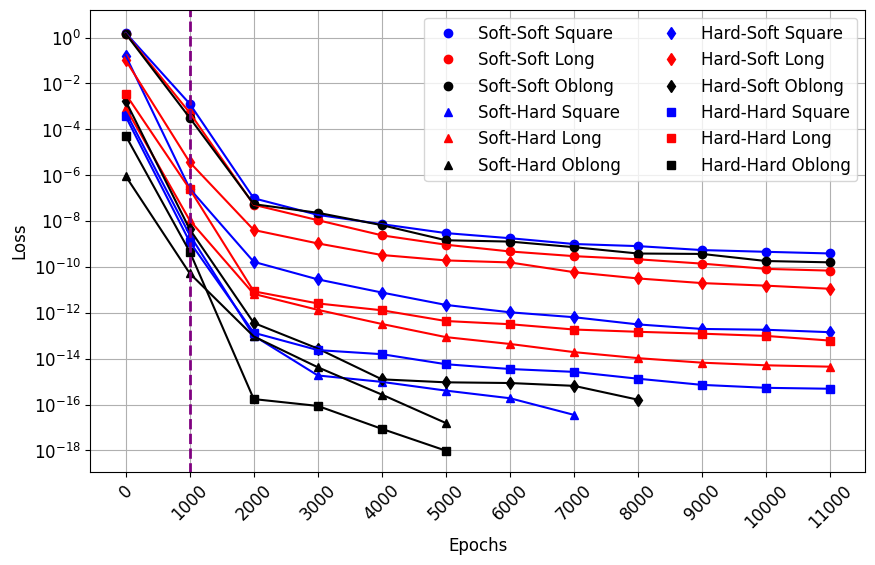

In [427]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(loss1)-1,1), loss1[:-1], 'o', color='blue')
plt.plot(np.arange(0,len(loss2)-1,1), loss2[:-1], 'o', color='red')
plt.plot(np.arange(0,len(loss3)-1,1), loss3[:-1], 'o', color='black')

plt.plot(np.arange(0,len(loss4)-1,1), loss4[:-1], '^', color='blue')
plt.plot(np.arange(0,len(loss5)-1,1), loss5[:-1], '^', color='red')
plt.plot(np.arange(0,len(loss6)-1,1), loss6[:-1], '^', color='black')

plt.plot(np.arange(0,len(loss7)-1,1), loss7[:-1], 'd', color='blue')
plt.plot(np.arange(0,len(loss8)-1,1), loss8[:-1], 'd', color='red')
plt.plot(np.arange(0,len(loss9)-1,1), loss9[:-1], 'd', color='black')

plt.plot(np.arange(0,len(loss10)-1,1), loss10[:-1], 's', color='blue')
plt.plot(np.arange(0,len(loss11)-1,1), loss11[:-1], 's', color='red')
plt.plot(np.arange(0,len(loss12)-1,1), loss12[:-1], 's', color='black')

plt.plot(np.arange(0,len(loss1)-1,1), loss1[:-1], color='blue')
plt.plot(np.arange(0,len(loss2)-1,1), loss2[:-1], color='red')
plt.plot(np.arange(0,len(loss3)-1,1), loss3[:-1], color='black')

plt.plot(np.arange(0,len(loss4)-1,1), loss4[:-1], color='blue')
plt.plot(np.arange(0,len(loss5)-1,1), loss5[:-1], color='red')
plt.plot(np.arange(0,len(loss6)-1,1), loss6[:-1], color='black')

plt.plot(np.arange(0,len(loss7)-1,1), loss7[:-1], color='blue')
plt.plot(np.arange(0,len(loss8)-1,1), loss8[:-1], color='red')
plt.plot(np.arange(0,len(loss9)-1,1), loss9[:-1], color='black')

plt.plot(np.arange(0,len(loss10)-1,1), loss10[:-1], color='blue')
plt.plot(np.arange(0,len(loss11)-1,1), loss11[:-1], color='red')
plt.plot(np.arange(0,len(loss12)-1,1), loss12[:-1], color='black')

#plt.title('(a)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.grid()

plt.vlines(x=1, ymin=0.0000000000000000001, ymax=100, colors='purple', ls='--', lw=2)

plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['0','1000','2000','3000','4000','5000','6000','7000','8000','9000','10000','11000'], rotation=45)
plt.yticks([10**0,10**-2,10**-4,10**-6,10**-8,10**-10,10**-12,10**-14,10**-16,10**-18])

plt.legend(['Soft-Soft Square','Soft-Soft Long','Soft-Soft Oblong','Soft-Hard Square','Soft-Hard Long','Soft-Hard Oblong', 
           'Hard-Soft Square','Hard-Soft Long','Hard-Soft Oblong', 'Hard-Hard Square','Hard-Hard Long','Hard-Hard Oblong'], ncol=2, loc = "upper right")

plt.savefig("burgers_loss_pic", bbox_inches = 'tight')

In [215]:
t = data_ss.train_x_all[:,2]
x = data_ss.train_x_all[:,0]
y = data_ss.train_x_all[:,1]

In [207]:
t = np.full_like(x, 1)

In [12]:
y = np.full_like(x, 0)

In [208]:
def u(x,y,t):
    return 1/(1 + np.exp((x+y-t)/0.2))

In [209]:
u_exact = u(x,y,t)

u_square_ss = model_square_ss.predict(np.vstack((x,y,t)).T)
u_long_ss = model_long_ss.predict(np.vstack((x,y,t)).T)
u_oblong_ss = model_oblong_ss.predict(np.vstack((x,y,t)).T)

u_square_sh = model_square_sh.predict(np.vstack((x,y,t)).T)
u_long_sh = model_long_sh.predict(np.vstack((x,y,t)).T)
u_oblong_sh = model_oblong_sh.predict(np.vstack((x,y,t)).T)

u_square_hs = model_square_hs.predict(np.vstack((x,y,t)).T)
u_long_hs = model_long_hs.predict(np.vstack((x,y,t)).T)
u_oblong_hs = model_oblong_hs.predict(np.vstack((x,y,t)).T)

u_square_hh = model_square_hh.predict(np.vstack((x,y,t)).T)
u_long_hh = model_long_hh.predict(np.vstack((x,y,t)).T)
u_oblong_hh = model_oblong_hh.predict(np.vstack((x,y,t)).T)

In [210]:
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_square_ss.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_long_ss.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_oblong_ss.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_square_sh.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_long_sh.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_oblong_sh.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_square_hs.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_long_hs.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_oblong_hs.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_square_hh.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_long_hh.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_oblong_hh.flatten(),15)))

8.875107400971098e-06
2.2374267000208694e-06
4.627916891306371e-06
9.675890509139583e-10
7.975948183052437e-09
4.17394338010252e-10
1.4423820765839186e-07
1.1917102764146383e-06
2.946974392270749e-09
1.726476080795559e-09
2.7602312759608207e-08
8.473539879411853e-11


In [213]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0, 1, 0, 1]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel()))

In [221]:
t = np.full_like(points[0], 1)

In [222]:
u_exact = u(points[0],points[1],t)

u_square_ss = model_square_ss.predict(np.vstack((points[0],points[1],t)).T)
u_long_ss = model_long_ss.predict(np.vstack((points[0],points[1],t)).T)
u_oblong_ss = model_oblong_ss.predict(np.vstack((points[0],points[1],t)).T)

u_square_sh = model_square_sh.predict(np.vstack((points[0],points[1],t)).T)
u_long_sh = model_long_sh.predict(np.vstack((points[0],points[1],t)).T)
u_oblong_sh = model_oblong_sh.predict(np.vstack((points[0],points[1],t)).T)

u_square_hs = model_square_hs.predict(np.vstack((points[0],points[1],t)).T)
u_long_hs = model_long_hs.predict(np.vstack((points[0],points[1],t)).T)
u_oblong_hs = model_oblong_hs.predict(np.vstack((points[0],points[1],t)).T)

u_square_hh = model_square_hh.predict(np.vstack((points[0],points[1],t)).T)
u_long_hh = model_long_hh.predict(np.vstack((points[0],points[1],t)).T)
u_oblong_hh = model_oblong_hh.predict(np.vstack((points[0],points[1],t)).T)

In [288]:
from matplotlib import cm, ticker

In [315]:
10**-4

0.0001

In [337]:
import matplotlib as mpl

C:\Users\charl\AppData\Local\Temp\ipykernel_15804\2137739431.py:48: UserWarning: Log scale: values of z <= 0 have been masked
  er4 = ax4.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
C:\Users\charl\AppData\Local\Temp\ipykernel_15804\2137739431.py:59: UserWarning: Log scale: values of z <= 0 have been masked
  er5 = ax5.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
C:\Users\charl\AppData\Local\Temp\ipykernel_15804\2137739431.py:70: UserWarning: Log scale: values of z <= 0 have been masked
  er6 = ax6.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
C:\Users\charl\AppData\Local\Temp\ipykernel_15804\2137739431.py:116: UserWarning: Log scale: values of z <= 0 have been masked
  er10 = ax10.contourf(plo

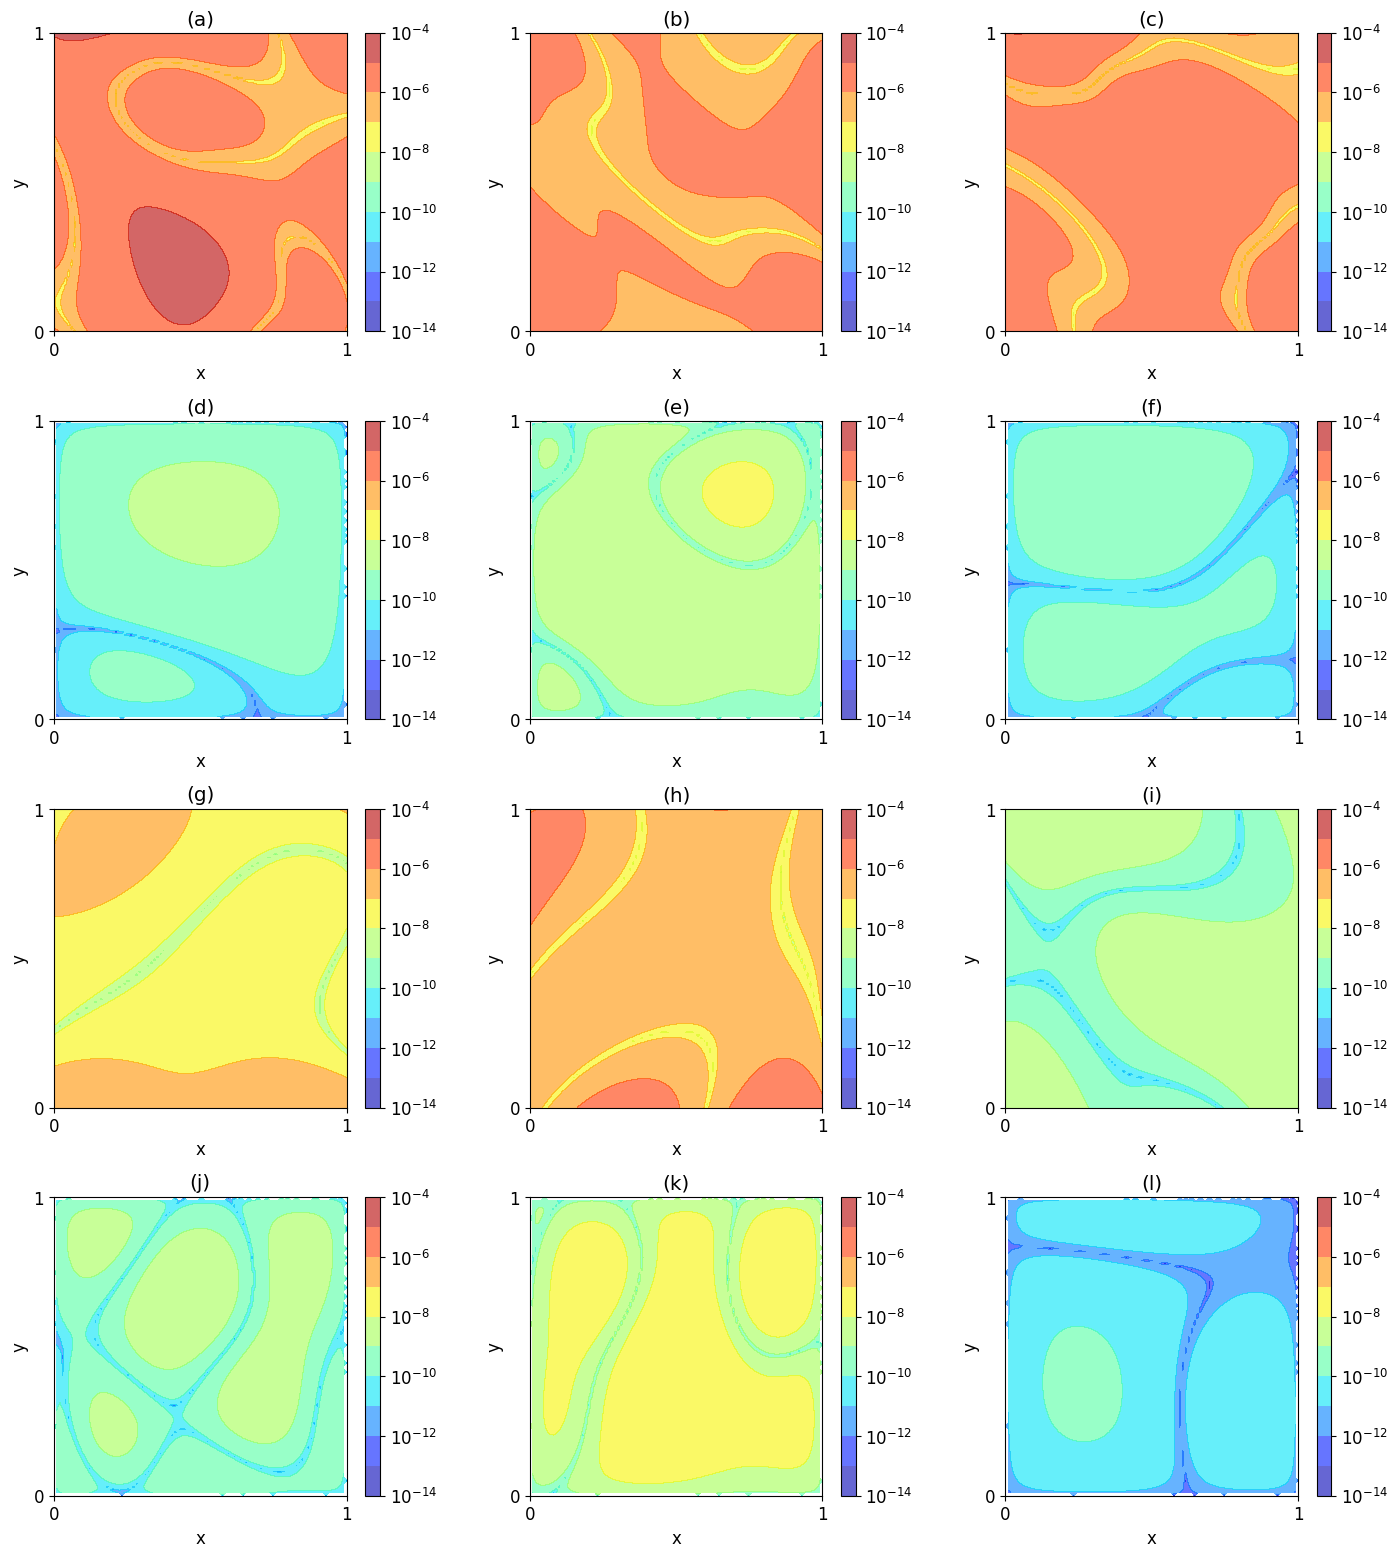

In [402]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(17,19))

levels = np.logspace(np.log10(10**-14), np.log10(10**-4), num=11)

#IMAGE 1
ax1 = fig.add_subplot(4,3,1)
error_square = np.abs(u_square_ss.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er1 = ax1.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('(a)');
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
#IMAGE 2
ax2 = fig.add_subplot(4,3,2)
error_long = np.abs(u_long_ss.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er2 = ax2.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('(b)');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
#IMAGE 3
ax3 = fig.add_subplot(4,3,3)
error_oblong = np.abs(u_oblong_ss.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er3 = ax3.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('(c)');
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])

#IMAGE 4
ax4 = fig.add_subplot(4,3,4)
error_square = np.abs(u_square_sh.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er4 = ax4.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('(d)');
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])
#IMAGE 5
ax5 = fig.add_subplot(4,3,5)
error_long = np.abs(u_long_sh.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er5 = ax5.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title('(e)');
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_xticks([0,1])
ax5.set_yticks([0,1])
#IMAGE 6
ax6 = fig.add_subplot(4,3,6)
error_oblong = np.abs(u_oblong_sh.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er6 = ax6.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_title('(f)');
ax6.set_xlabel('x')
ax6.set_ylabel('y')
ax6.set_xticks([0,1])
ax6.set_yticks([0,1])

#IMAGE 7
ax7 = fig.add_subplot(4,3,7)
error_square = np.abs(u_square_hs.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er7 = ax7.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax7.set_xticks([])
ax7.set_yticks([])
ax7.set_title('(g)');
ax7.set_xlabel('x')
ax7.set_ylabel('y')
ax7.set_xticks([0,1])
ax7.set_yticks([0,1])
#IMAGE 8
ax8 = fig.add_subplot(4,3,8)
error_long = np.abs(u_long_hs.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er8 = ax8.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax8.set_xticks([])
ax8.set_yticks([])
ax8.set_title('(h)');
ax8.set_xlabel('x')
ax8.set_ylabel('y')
ax8.set_xticks([0,1])
ax8.set_yticks([0,1])
#IMAGE 9
ax9 = fig.add_subplot(4,3,9)
error_oblong = np.abs(u_oblong_hs.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er9 = ax9.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax9.set_xticks([])
ax9.set_yticks([])
ax9.set_title('(i)');
ax9.set_xlabel('x')
ax9.set_ylabel('y')
ax9.set_xticks([0,1])
ax9.set_yticks([0,1])

#IMAGE 10
ax10 = fig.add_subplot(4,3,10)
error_square = np.abs(u_square_hh.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er10 = ax10.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax10.set_xticks([])
ax10.set_yticks([])
ax10.set_title('(j)');
ax10.set_xlabel('x')
ax10.set_ylabel('y')
ax10.set_xticks([0,1])
ax10.set_yticks([0,1])
#IMAGE 11
ax11 = fig.add_subplot(4,3,11)
error_long = np.abs(u_long_hh.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er11 = ax11.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax11.set_xticks([])
ax11.set_yticks([])
ax11.set_title('(k)');
ax11.set_xlabel('x')
ax11.set_ylabel('y')
ax11.set_xticks([0,1])
ax11.set_yticks([0,1])
#IMAGE 12
ax12 = fig.add_subplot(4,3,12)
error_oblong = np.abs(u_oblong_hh.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er12 = ax12.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-14, vmax=10**-4, levels=levels)
ax12.set_xticks([])
ax12.set_yticks([])
ax12.set_title('(l)');
ax12.set_xlabel('x')
ax12.set_ylabel('y')
ax12.set_xticks([0,1])
ax12.set_yticks([0,1])

fig.colorbar(er1)
fig.colorbar(er2)
fig.colorbar(er3)
fig.colorbar(er4)
fig.colorbar(er5)
fig.colorbar(er6)
fig.colorbar(er7)
fig.colorbar(er8)
fig.colorbar(er9)
fig.colorbar(er10)
fig.colorbar(er11)
fig.colorbar(er12)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
#plt.savefig("burger_error", bbox_inches = 'tight')

In [ ]:
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er4, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er4, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er4, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax7)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er7, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax8)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er7, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax9)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er7, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax10)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er10, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax11)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er10, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax12)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er10, cax=cax, orientation='vertical')

In [ ]:
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-7}$')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-7}$')

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-7}$')

In [ ]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

z = data.train_x_all[:,2]
x = data.train_x_all[:,0]
y = data.train_x_all[:,1]
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
 
# Creating plot
ax.scatter3D(x, y, z, color = "dodgerblue")
#ax.scatter3D(data.train_x_bc[:,0], data.train_x_bc[:,1], data.train_x_bc[:,2], color = "green")
#ax.scatter3D(data.train_x_all[:100,0], data.train_x_all[:100,1], data.train_x_all[:100,2], color = "purple")
plt.title("Initial, boundary and collocation points")
ax.set_zlim(-0.01,2)
# show plot
#plt.show()
plt.savefig("burgers_soft_points_all", bbox_inches = 'tight')